# This notebook serves as walkthrough for planning an experiment for creation through the OT2.
### The following modules are used and should be in the same directory as this notebook: 
* **CreateSamples** is responsible for calculating sample information, which includes component weight fractions and stock volumes
* **OT2Commands** is responsible for setting up information to be interpretted and executed by opentrons **BASED ON THE LATEST API 2.3 and above**
* **OT2Graphing** contains graphing tools to help visualize and explore parameter spaces.

In [7]:
from Plan import CreateSamples_renewed
from Prepare import OT2Commands as ALH
from Prepare import OT2Graphing as ographing
from opentrons import simulate, execute, protocol_api

### Step 1: Set up the experiment dictionary.
The first step to planning an experiment is to load the experiment variables and inputs from a csv file. 
- **Within the Testing Plans Folder you should find a templete of a testing plan (open in Excel for easier viewing).**

Currently the info is split up between two sections: Variables for creating sample spaces and variables for OT2 commands. You only need to specify for the sections you will use.

The experiment dictionary consist of keys being the variable name and the value being the variables value. Keep in mind the order of listed variables assumptions should be the index of one listed variable refers to the same index of a related variable.

Besides the plan, if planning on creating a sample space you will need to:
- Update/verify the csv chemical database with/for component information.
- Provide the path of the updated chemical csv for plan. 

Most funcitons will expect you to load in the variable from the dictionary as dict[variable_name]

In [8]:
path = r"Testing Plans\05_10_21_CdSe_Ligand_Study.csv"
chem_path = r"Chemical Database.csv"
plan = CreateSamples_renewed.get_experiment_plan(path, chem_path)

### Step 2: Select and Create Sampling Space
The sampling method will depend on the type of sample units, the actual called method (i.e. lattic, non-clustering random..etc) and whether you are providing arguments from the plan in step 1 or importing sample information from elsewhere. 

***Note:*** All information will be stored as a dataframe
 
You can utilize the built in functions in functions to create sample concentration spaces as follows:
- concentration_from_csv: Import csv with headers being component name and concentration unit.
- concentration_from_excel: Import from excel with headers being component name and concentration unit.
- concentration_from_linspace: Pull from plan the linspaces to use lattice or random sampling. Optional: Unity filter allows for last indexed component to be used a completing component. 
- concentration_from_list_samplewise: 
- concentration_from_list_componentwise:
 
**The ONE requirement if you plan to use any of the module functions is you adhere to strict naming convention. This allows the functions to identify key values to use to calculate and determine specific informaiton (i.e. mass, volume to pipette). **

The following conventions are:
- component concentration columns: Should have the term "concentration" and the concentration unit name (i.e. DPPC Concentration Molarity). 
-

In [9]:
concentration_df = CreateSamples_renewed.concentration_from_linspace(plan['Component Shorthand Names'], 
                                                                     plan['Component Concentration Linspaces [min, max, n]'],
                                                                     plan['Component Concentration Units'],
                                                                     unity_filter=False)
concentration_df

,CdAc concentration molarity,Se concentration molarity,OleicAc concentration molarity,Oleylamine concentration molarity
0,0.0,0.0,0.00,0.00
1,0.0,0.0,0.00,0.25
2,0.0,0.0,0.00,0.50
3,0.0,0.0,0.25,0.00
4,0.0,0.0,0.25,0.25
...,...,...,...,...
76,0.1,0.1,0.25,0.25
77,0.1,0.1,0.25,0.50
78,0.1,0.1,0.50,0.00
79,0.1,0.1,0.50,0.25


### Step 3: Create Stock Dictionary
The stock dictionary will hold the stock information which will be used to calculate for stock volumes for the OT2.
The stock dictionary function will take 3 main sets of information (all formatted as lists, matched by index). 
- Stock Names: Stock names are to be formatted as solute1-solute2...soluten-solvent-stock i.e. NaCl-water-stock.
    - The solutes and solvents are expected to be in the chemical dictionary provided in step 1 as information such as density and molecular weight will be used in volume calculations.
- Stock Concentration Units: Any conc units supported (see function).
- Stock Concentrations: Value of stock conc.

In [10]:
stock_dict = CreateSamples_renewed.stock_dictionary(plan['Stock Names'], 
                                                    plan['Stock Concentration Units'], 
                                                    plan['Stock Concentrations'])

### Step 3: Calculate Component Amounts Mass And Volumes
The end goal in this component planning is to calculate for stock volumes, this requires knowledge on the component mass/volumes (depending on component units and stock units). See ______ for a map of how specific component concentration untis and stock units pair together to calculate for info. 

For now there exist one general function *determine_component_amounts* which based on the stock and component conc units will use the appropiate function to calculate for component mass and volume amounts. 

Since this step uses information from the chemical database, if that information is missing or not avaible then the resulting values will return as nan. To remove these and replace with zero ____

In [27]:
complete_amounts_added = CreateSamples_renewed.determine_component_amounts(plan, concentration_df, nan_fill_value=0)


[1.0, 1.0, 1.67, 0.79, 1.0] [734.039, 2805.5, 41.07, 323.0, 1.0]


,dppc-ethanol-stock uL,dspepeg2000-ethanol-stock uL,pfh-ethanol-stock uL,ethanol-stock uL,water-stock uL,Total Sample Volume uL
0,30.000043,33.267986,0.000000,-63.268028,799.912000,799.912000
1,30.000043,33.267986,0.000000,-34.051892,770.438316,799.654452
2,30.000043,33.267986,0.000000,-5.107819,740.964632,799.124840
3,30.000043,33.267986,0.000000,23.543485,711.490947,798.302461
4,30.000043,33.267986,0.000000,51.879776,682.017263,797.165068
...,...,...,...,...,...,...
495,30.000043,33.267986,1012.658228,-672.056691,349.806737,753.676302
496,30.000043,33.267986,1012.658228,-649.375089,320.333053,746.884219
497,30.000043,33.267986,1012.658228,-627.297466,290.859368,739.488158
498,30.000043,33.267986,1012.658228,-605.835241,261.385684,731.476699


### Step 3: Calculate Volumes of Stocks
From the concentration values calculated in Step 2, we use those along with stock concentration information to calculate the volume of required for each sample.
* This is where things get less "*general*" each case depending on the number of stocks, common components (i.e. component A in both stock A and B) and other requirements will typically require its own function. Luckily given the commmonality of using data frames this should be quite simple. 
    * Currently the only function to calculate volumes in centered around the Ouzo emulsion systems. This system consist of 3 stocks with the solvent being ethanol and two pure stocks of ethanol and water = *CreateSamples.calculate_ouzo_volumes_from_wtf*
    * To identify solutes and solvents in stock the notation of stock is solute1-solute2-.....-soluten-solvent. 

In [ ]:
complete_df = CreateSamples_renewed.calculate_stock_volumes_from_component_concs(plan, complete_amounts_added, stock_dict)
complete_df= CreateSamples_renewed.complete_missing_volume_with_commmon_solvent(plan['Sample Amount'], complete_df, stock_dict, 'Octadecene')
complete_df_uL = CreateSamples_renewed.convert_mL_to_uL(complete_df)
stock_volumes = CreateSamples_renewed.isolate_common_column(complete_df_uL, 'stock')

### Step 4: Apply Filters or Other Selection Criteria 

It is essential to combine both the concentration and volume dataframes made in Step 2 and 3 into one dataframe such that when we apply filters we apply it all samples values. We do this through the *CreateSamples.combine_df_hotdog* function.

**Filters**: The types of filters can be added easily through dataframe logic. For example, ones in the CreateSamples module:
   * *pipette_volume_restriction_df* = Given the lower and upper ranges of the two sets of pipettes you will use to synthesize the samples, will remove anything not in range or zero. 
   * *total_volume_restriction_df* = Restrict total volume, mostly based on labware constraints. Column selection based on "total". 
   * *general_max_restriction_df* = provide max value and column name 
   * *general_min_restriction_df* = provide min value and column name 
   
**Other Selection Critera**
   * *.multiplydf(n, df)* = Will multiply a data frame by n number of times. Useful when making one sample repeatadly.
   * a specfic concentration or volume

In [28]:
complete_df_unfiltered = CreateSamples.combine_df_hotdog(concentration_canidates, volume_canidates)
complete_df_filtered = CreateSamples.pipette_volume_restriction_df(complete_df_unfiltered, 20, 1000, ['N', 'N', 'N', 'N', 'Y'])
complete_df_filtered = CreateSamples.total_volume_restriction_df(complete_df_filtered, 1500)
len(complete_df_filtered)

96

### Step 4a (Optional): Visual
If you would like, you can visual the space you are sampling by calling up to 3 columns of interest from the componsitional space. The module OT2Graphing will contain helpful function to visualize the sampling space.
* Note: Given limitation with adding packages to OT2, anything utilziing matplotlib will not work on the OT2's native jupyter notebook. This is currently the only module which references it. 

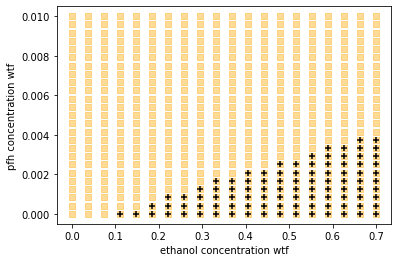

In [29]:
ographing.xy_scatter_df_compare(complete_df_unfiltered, complete_df_filtered, 'ethanol concentration wtf', 'pfh concentration wtf')

### Step 5: Addition of Blanks/Standards
The most accurate way to blank samples or compare to standards is to create a sample without components of interest for every sample made in the prior dataframes.

The most straightforward way of doing this is by calling which columns you will be removing/zeroing out. If concentration units are non-unity (i.e. mg/mL or molarity) thats it. If unity based (volf, molf...) then you will need to take that removed value and add to to another component. Finally, recalculate volumes like you did in Step 3. 
* Following this will make a blank for each sample which can be wasteful, so filter for duplicates. 
* You may need to filter based on volume again depending on your protocol/system as volumes will change slightly for each component.

Note: If unity completing option used in Step 1 then add to that completing component.

In [8]:
# remove_components = ['dppc concentration wtf', 'dspepeg200 concentration wtf', 'pfh concentration wtf']
# add_to = 'water concentration wtf'  


# blanked_compositions = CreateSamples.blank_sum_to_end(complete_df_filtered, remove_components, add_to)
# blanked_compositions_nondup = CreateSamples.remove_duplicates(blanked_compositions, 3)
# blank_volumes = CreateSamples.calculate_ouzo_volumes_from_wtf(blanked_compositions_nondup, plan)
# blank_complete_df = CreateSamples.combine_df_hotdog(blanked_compositions_nondup, blank_volumes)

## Step 6: Finalize and Call Seperate Concentration and Volume Dataframes
Now that we have made the appropiate complete sample and blank dataframes we are to combine them into one for better handling. Afterwards we seperate the entirely new and final dataframe on the basis of concentration and stock volume unit. 
*We seperate to allow for easier handiling of creating a final dataframe for exporting and reporting volumes to the OT2 for execution/simulation.*

In [9]:
# final_complete_df = CreateSamples.combine_df_hamburger(complete_df_filtered, blank_complete_df)
final_complete_df = complete_df_filtered
final_composition_df = CreateSamples.isolate_common_column(final_complete_df, 'concentration')
final_volume_df = CreateSamples.isolate_common_column(final_complete_df, 'stock')
final_volume_df.reset_index(inplace = True, drop = True)
final_volume_df

,dppc-ethanol-stock uL,dspepeg2000-ethanol-stock uL,pfh-ethanol-stock uL,ethanol-stock uL,water-stock uL
0,30.000043,33.446562,0.000000,23.364909,711.490947
1,30.000043,33.446562,0.000000,51.701200,682.017263
2,30.000043,33.446562,0.000000,79.699001,652.543579
3,30.000043,33.446562,0.000000,107.333914,623.069895
4,30.000043,33.446562,0.000000,134.580925,593.596211
...,...,...,...,...,...
90,30.000043,33.446562,337.552743,44.435830,296.192702
91,30.000043,33.446562,337.552743,65.898055,266.719018
92,30.000043,33.446562,337.552743,86.736549,237.245333
93,30.000043,33.446562,379.746835,23.903563,266.385684


### Step 6 (Optional): Calculate Stock Prep Information

We can calculate stock information to make it easier to prepare these stock. This process if semi-general, currently supporting a few stock concentration units = mgperml, volf, wtf, molf and molarity. All of these require the basis of volume as that is what is driving how much sample we make for the OT2. 

The logic behind this relies on the notation of stocks = solute1-solute2-....solvent. Using notations allows for systematic handling of solutes and solvent determining what is needed based on information from a excel based Chemical Database.

*Reccomended*: Use at the minimum the default buffering (extra stock being made) of 40 percent to ensure you do not aspirate any air by mistake.

In [10]:
chem_database_path = r"Chemical Database.xlsx"
stock_prep_df = CreateSamples.calculate_stock_prep_df(plan, final_volume_df, chem_database_path, buffer_pct=50)
stock_prep_df

,dppc-ethanol-stock L,dspepeg2000-ethanol-stock L,pfh-ethanol-stock L,ethanol-stock L,water-stock L
solute mass g,0.008550,0.003990,0.147032,0.000000,0.000000
solute volume L,0.000000,0.000000,0.000087,0.000000,0.000000
solvent mass g,3.374262,3.761910,14.556148,18.955349,56.898802
solvent volume L,0.004275,0.004766,0.018442,0.024015,0.056899


### Step 8: Simulate/Execute
* The main information needed to create commands for the OT2 is the position of the stocks and the volumes in respect to each well you would like to move the stock to. All volumes in sent to the OT2 will be interpretted as microliters (uL). 
    * Stock Volumes: We have calculated this in step 3. The way we prepare these samples can vary, which is what were refer to as the *pipetteing strategy*.
        * Pipetting Strategy 1: Add each stock to all wells then move onto next stock. The upside to this is the simplicity of the written protocol. It has a downside of using more tips. It can allow for evaporation or other time sensitve process to occur in the time between stock additions.
        * Pipetting Strategy 2: Adding all stocks to a well then moving on. 

### Step 8a Optional: Load custom labware dictionary (Remote Testing)
* Provide the path to the directory holding all custom labware. This directory should have custom labware .json files you have previously made and tested, read more here: https://support.opentrons.com/en/articles/3136504-creating-custom-labware-definitions
* The reason we provide this is when working on a device that is not connected to the OT2's Jupyter notebook there is no way to natively use custom labware. So we create a dictionary of custom labware so we can later load into our protocol to primarily simualte and test protocols for execution later once connnected to the OT2's notebook.
    * When using custom labware on the OT2's notebook it pulls from a folder labeled "labware", which is something built into the Opentrons hardware. It has not been tested if the custom labware dictionary will superceed this directory of custom labware if used on the OT2.
    * The custom labware folder should contain everything the OT2 labware folder contains: ADD GDRIVE link to customize
    
* **NOTE: Any function using the custom_labware_dict, the argument is optional so can remove and should receive same output IF working on OT2 computer.**

Just noted: transfer_info will fail if transfer and distribute used together, well not fail jsut need to concat

In [11]:
importlib.reload(ALH)

<module 'Prepare.OT2Commands' from 'C:\\Users\\Edwin\\Desktop\\OT2-DOE\\PlanPrepareProcess\\Prepare\\OT2Commands.py'>

In [12]:
labware_dir_path = r"Custom Labware"
custom_labware_dict = ALH.custom_labware_dict(labware_dir_path)
# ALH.find_max_stock_volume_labware(plan,custom_labware_dict=custom_labware_dict)
custom_labware_dict

{'Custom Labware\\20mlscintillation_12_wellplate_18000ul': {'ordering': [['A1',
    'B1',
    'C1'],
   ['A2', 'B2', 'C2'],
   ['A3', 'B3', 'C3'],
   ['A4', 'B4', 'C4']],
  'brand': {'brand': '20mLscintillation', 'brandId': []},
  'metadata': {'displayName': '20mLscintillation 12 Well Plate 18000 ÂµL',
   'displayCategory': 'wellPlate',
   'displayVolumeUnits': 'ÂµL',
   'tags': []},
  'dimensions': {'xDimension': 127.7, 'yDimension': 85.8, 'zDimension': 60.5},
  'wells': {'A1': {'depth': 53,
    'totalLiquidVolume': 18000,
    'shape': 'circular',
    'diameter': 27.85,
    'x': 21.81,
    'y': 70.69,
    'z': 7.5},
   'B1': {'depth': 53,
    'totalLiquidVolume': 18000,
    'shape': 'circular',
    'diameter': 27.85,
    'x': 21.81,
    'y': 42.86,
    'z': 7.5},
   'C1': {'depth': 53,
    'totalLiquidVolume': 18000,
    'shape': 'circular',
    'diameter': 27.85,
    'x': 21.81,
    'y': 15.03,
    'z': 7.5},
   'A2': {'depth': 53,
    'totalLiquidVolume': 18000,
    'shape': 'circul

### Set up Loaded Dictionary and Directions for Volume Handling
It is important to know how many stock container will be needed for each stock and be able to provide the correct instructions for OT2 commands to follow.

The ranges of stock refers to the ranges of wells one stock will cover. The range is provided in terms of the index of the stock volume dataframe i.e.([lower, upper])). The format is as follows = [[stock1_range1, stock1_range2....], [stock2_range1, stock2_range2....] []...].

The basis of range is on the maximum volume of the stock container, however currently limitation are: 
 * All stock containers must be the same
 * Each component must have its own stock - need to test verify

In [15]:
protocol = simulate.get_protocol_api('2.3', extra_labware=custom_labware_dict)
loaded_dict = ALH.loading_labware(protocol, plan)
loaded_dict = ALH.determine_pipette_resolution(loaded_dict) # this should just be automatically called move into function
max_source_vol = 15000
stock_position_info = ALH.stock_well_ranges(loaded_dict, final_volume_df, max_source_vol) 
stock_position_info


C:\Users\Edwin\.opentrons\robot_settings.json not found. Loading defaults
C:\Users\Edwin\.opentrons\deck_calibration.json not found. Loading defaults


{'dppc-ethanol-stock uL': {'Ranges': [[0, 95]],
  'Stock Wells': [A1 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1]},
 'dspepeg2000-ethanol-stock uL': {'Ranges': [[0, 95]],
  'Stock Wells': [A2 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1]},
 'pfh-ethanol-stock uL': {'Ranges': [[0, 95]],
  'Stock Wells': [A3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1]},
 'ethanol-stock uL': {'Ranges': [[0, 82], [82, 95]],
  'Stock Wells': [A4 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1,
   B1 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1]},
 'water-stock uL': {'Ranges': [[0, 32], [32, 69], [69, 95]],
  'Stock Wells': [B2 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1,
   B3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1,
   B4 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1]}}

In [14]:
directions = ALH.create_sample_making_directions(final_volume_df, stock_position_info, loaded_dict)
transfer_info = ALH.pipette_volumes_sample_wise(protocol, directions, loaded_dict)

Picking up tip from A1 of Opentrons 96 Tip Rack 300 µL on 10
Transferring 30.000042611565522 from A1 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 to A1 of Falcon 48 Well Plate 1500 ÂµL on 2
Aspirating 30.000042611565522 uL from A1 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 50.0 uL/sec
Dispensing 30.000042611565522 uL into A1 of Falcon 48 Well Plate 1500 ÂµL on 2 at 300.0 uL/sec
Returning tip
Dropping tip into A1 of Opentrons 96 Tip Rack 300 µL on 10
Picking up tip from A2 of Opentrons 96 Tip Rack 300 µL on 10
Transferring 33.44656189053347 from A2 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 to A1 of Falcon 48 Well Plate 1500 ÂµL on 2
Aspirating 33.44656189053347 uL from A2 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 50.0 uL/sec
Dispensing 33.44656189053347 uL into A1 of Falcon 48 Well Plate 1500 ÂµL on 2 at 300.0 uL/sec
Returning tip
Dropping tip into A2 of Opentrons 96 Tip Rack 300 µL on 10
Picking up tip from A3 of Opentrons 96 Tip Rack 300 µL on 10
Tran

Aspirating 126.58227848101266 uL from A3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 50.0 uL/sec
Dispensing 126.58227848101266 uL into A6 of Falcon 48 Well Plate 1500 ÂµL on 3 at 300.0 uL/sec
Returning tip
Dropping tip into A3 of Opentrons 96 Tip Rack 300 µL on 10
Picking up tip from A4 of Opentrons 96 Tip Rack 300 µL on 10
Transferring 209.6490655473849 from A4 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 to A6 of Falcon 48 Well Plate 1500 ÂµL on 3
Aspirating 209.6490655473849 uL from A4 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 50.0 uL/sec
Dispensing 209.6490655473849 uL into A6 of Falcon 48 Well Plate 1500 ÂµL on 3 at 300.0 uL/sec
Returning tip
Dropping tip into A4 of Opentrons 96 Tip Rack 300 µL on 10
Picking up tip from A5 of Opentrons 96 Tip Rack 1000 µL on 11
Transferring 356.8067368421053 from B3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 to A6 of Falcon 48 Well Plate 1500 ÂµL on 3
Aspirating 356.8067368421053 uL from B3 of 20mLscintillation 12 W

In [ ]:
transfer_info = ALH.transfer_from_destination_to_final(protocol, loaded_dict, plan, len(final_volume_df))

### Step 9: Format for Exporting and Upload to Google Drive
* Using the information from our previously created dataframes we create a final dataframe to convert to a csv and upload to google drive for storage. 
    * Currently the two main pieces of information uploaded are composition of sample and sample location information. This for each sample is tied to a unique ID which contains a well_timestamp_keyword. 

* Currently the function *CreateSamples.create_df* uses information from *ALH.pipette_stock_volumes* along with the values of the composition dataframe and experiment dict to create a final df for exporting. It is not super general so will work on seperating the information slicing and dataframe combination - its quite tangeled and needs to be generalized. 

* Once you create your dataframe (where every row/index = one unique sample) then we can convert it to a csv and upload to google drive/store.

In [ ]:
export_df = CreateSamples.create_df(transfer_info, final_composition_df.values, plan, unique_identifier='Right')
export_df = CreateSamples.combine_df_hotdog(export_df, final_volume_df) 

In [ ]:
temp_hold_path = r"Hold_Info"
export_df.to_csv(temp_hold_path, index=False)

### Navigate/Create (to) respective folder on Google Drive
1. Call an instance of your google drive, this is statically the Pozzo Team Drive using *CreateSamples.team_drive_dict()*. This should open a new window prompting you for credentials. It will also return a dictionary of the highest level folders name and unique ID. **The unique ID is what will let you navigate**
2. Once inside the Team Drive use *CreateSamples.file_and_folder_navi(unique_ID)* by selecting a certain root level folder from step 1. Then you can keep repeating this until you reach the level/directory of interest.
    * A way to bypass this is to log into google drive and find the unique ID manually EXPLAIN
3. Once you have reached the level of interest, create the folder if necessary. 
4. With the folder ID of interest then use *upload_to_team_drive_folder* providing the path and name of file along with final destination (the ID you found/made from step 2/3). This will upload the respective files to that level. 
5. Cry




* Add the option to create a new folder - as a function to the package. 
* looks like OT2 can not at all upload any sort of package - so will need to make it clear to only use the drive portion of package on remote computer - hence why we should switch to using the module and having notebooks ayt surface level.

In [ ]:
from Prepare import UploadDrive
importlib.reload(UploadDrive)

In [ ]:
UploadDrive.initialize_connection(r"C:\Users\Edwin\Desktop\OT2creds.txt")

In [ ]:
UploadDrive.team_drive_dict(r"C:\Users\Edwin\Desktop\OT2creds.txt")

In [ ]:
current_members = UploadDrive.file_and_folder_navi('1dXYmxuESNhgmVHntEf8hnZmjK0Br8b64')
# UploadDrive.file_and_folder_navi('1CDnoLE32bG0BFhhvCl5JlRFO4I_ga-eJ')

In [ ]:
plan_file_path = experiment_plan_path
synthesis_info_file_path = r"sample_info"
folder_to_place_id = '1YdAqr1kYFEuRc8wyd9dcyzo0BWW68-1P'

# CreateSamples.upload_to_team_drive_folder(folder_to_place_id, plan_file_path, 'Experiment Plan Info')
CreateSamples.upload_to_team_drive_folder(folder_to_place_id, synthesis_info_file_path, 'Experiment Synthesis Info')